In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import xarray as xr
import string
from glob import glob
import re
import cartopy.crs as ccrs
from matplotlib_scalebar.scalebar import ScaleBar
from ast import literal_eval
import contextily as cx
from matplotlib.colors import ListedColormap
import geopandas as gpd
from shapely.geometry.point import Point
from pyproj.database import query_utm_crs_info
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
import itertools
from timezonefinder import TimezoneFinder
from pytz import timezone
import pytz

In [2]:

warnings.filterwarnings('ignore')

font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read plume nc and csv files

In [3]:
def read_data(data_dir):
    file_emit = glob(f'{data_dir}/JamesHMillerJr/EMIT*plume0.nc')[0]
    ds_emit = xr.open_dataset(file_emit)
    df_emit = pd.read_csv(file_emit.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval})
    
    # file_enmap = glob(f'{data_dir}/FourCorners/ENMAP*plume0.nc')[0]
    # ds_enmap = xr.open_dataset(file_enmap)
    # df_enmap = pd.read_csv(file_enmap.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval})
    
    file_prisma = glob(f'{data_dir}/Stanwell/PRS*plume0.nc')[0]
    ds_prisma = xr.open_dataset(file_prisma)
    df_prisma = pd.read_csv(file_prisma.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval})

    file_enmap = glob(f'{data_dir}/Rockport/ENMAP*plume0.nc')[0]
    ds_enmap = xr.open_dataset(file_enmap)
    df_enmap = pd.read_csv(file_enmap.replace('.nc', '.csv'), converters={'plume_bounds': literal_eval})

    return ds_emit, df_emit, ds_enmap, df_enmap, ds_prisma, df_prisma

In [4]:
ds_emit, df_emit, ds_enmap, df_enmap, ds_prisma, df_prisma = read_data('../data/co2_cases_mf/')
ds_emit_lmf, df_emit_lmf, ds_enmap_lmf, df_enmap_lmf, ds_prisma_lmf, df_prisma_lmf = read_data('../data/co2_cases_lmf/')

## Quantification summary

In [5]:
df_merge_mf = pd.concat([df_emit, df_enmap, df_prisma])
df_merge_lmf = pd.concat([df_emit_lmf, df_enmap_lmf, df_prisma_lmf])

df_merge_mf['emission'] /= 1e3
df_merge_mf['emission_csf'] /= 1e3
df_merge_mf['emission_uncertainty'] /= 1e3
df_merge_mf['emission_csf_uncertainty'] /= 1e3

df_merge_lmf['emission'] /= 1e3
df_merge_lmf['emission_csf'] /= 1e3
df_merge_lmf['emission_uncertainty'] /= 1e3
df_merge_lmf['emission_csf_uncertainty'] /= 1e3

Text(0, 0.5, 'CO$_2$ Emission Rate (t h$^{-1}$)')

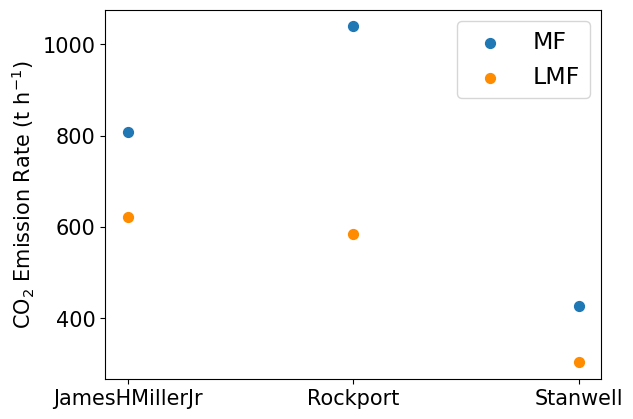

In [6]:
fig, axs = plt.subplots()
df_merge_mf.plot.scatter(ax=axs, x='name', y='emission', label='MF', c='C0', s=50)
df_merge_lmf.plot.scatter(ax=axs, x='name', y='emission', label='LMF', c='darkorange', s=50)
plt.xlabel('')
plt.ylabel('CO$_2$ Emission Rate (t h$^{-1}$)')

## Comparison with EPA data

In [7]:
def convert_to_utc(lat, lon, df):
    # Get timezone name from coordinates
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=lat, lng=lon)

    # Localize to the correct timezone
    local_tz = timezone(timezone_str)
    df['local_time'] = df['local_time'].dt.tz_localize(local_tz)
    
    # Convert to UTC
    df['datetime'] = df['local_time'].dt.tz_convert(pytz.UTC)

    return df

In [8]:
def find_nearest(df, target_time):
    target_time = pd.to_datetime(target_time).item().tz_localize('UTC')
    
    # Calculate the absolute difference
    df['time_diff'] = (df['datetime'] - target_time).abs()
    
    # Find the minimum difference
    min_diff = df['time_diff'].min()
    
    # Get all rows with that minimum difference
    nearest_rows = df[df['time_diff'] == min_diff]

    return nearest_rows

In [9]:
df_epa_emit = pd.concat(map(pd.read_csv, glob('../data/EPA/*JAMES_H_MILLER*.csv')))
df_epa_emit['local_time'] = pd.to_datetime(df_epa_emit['Date'] + ' ' + df_epa_emit['Hour'].astype(str), format='%Y-%m-%d %H')
df_epa_emit = convert_to_utc(df_emit['plume_latitude'].item(), df_emit['plume_longitude'].item(), df_epa_emit)
df_epa_emit = df_epa_emit[df_epa_emit['datetime'].dt.date == pd.to_datetime(df_emit['datetime']).item().date()]
df_epa_emit_nearest = find_nearest(df_epa_emit, df_emit['datetime'])

df_epa_enmap = pd.concat(map(pd.read_csv, glob('../data/EPA/*ROCKPORT*.csv')))
df_epa_enmap['local_time'] = pd.to_datetime(df_epa_enmap['Date'] + ' ' + df_epa_enmap['Hour'].astype(str), format='%Y-%m-%d %H')
df_epa_enmap = convert_to_utc(df_enmap['plume_latitude'].item(), df_enmap['plume_longitude'].item(), df_epa_enmap)
df_epa_enmap = df_epa_enmap[df_epa_enmap['datetime'].dt.date == pd.to_datetime(df_enmap['datetime']).item().date()]
df_epa_enmap_nearest = find_nearest(df_epa_enmap, df_enmap['datetime'])

In [10]:
def plot_tseries(ax, df, df_nearest):
    df['utc_hour'] = df['datetime'].dt.hour
    df_nearest['utc_hour'] = df_nearest['datetime'].dt.hour
    
    df_pivot = df.pivot_table(values='CO2 Mass (short tons)', index='utc_hour', columns='Unit ID', aggfunc='sum')
    df_nearest_pivot = df_nearest.pivot_table(values='CO2 Mass (short tons)', index='utc_hour', columns='Unit ID', aggfunc='sum')
    
    # Plot
    df_pivot.plot(kind='area', stacked=True, ax=ax, alpha=0.5, cmap='Dark2')
    
    # Add dashed line
    dash_hour = df_nearest_pivot.index.item()
    co2_at_dash = df_nearest_pivot.loc[dash_hour].sum()
    ax.axvline(dash_hour, linestyle='--', color='k')
    ax.text(dash_hour-0.1, co2_at_dash,
            f'${int(co2_at_dash)}\\ \\mathrm{{t\\ h}}^{{-1}}$',
            ha='right', fontsize=17)
    ax.scatter(dash_hour, co2_at_dash, color='k', linewidth=2, marker='o', fc='none', s=50)

    ax.set_xlabel("Hour (UTC)")
    ax.set_xlim(10, 20)
    ax.set_ylabel("CO$_2$ Emission Rate (t h$^{-1}$)")
    ax.legend(title="Unit ID", loc='upper left', title_fontsize=15)

    return co2_at_dash

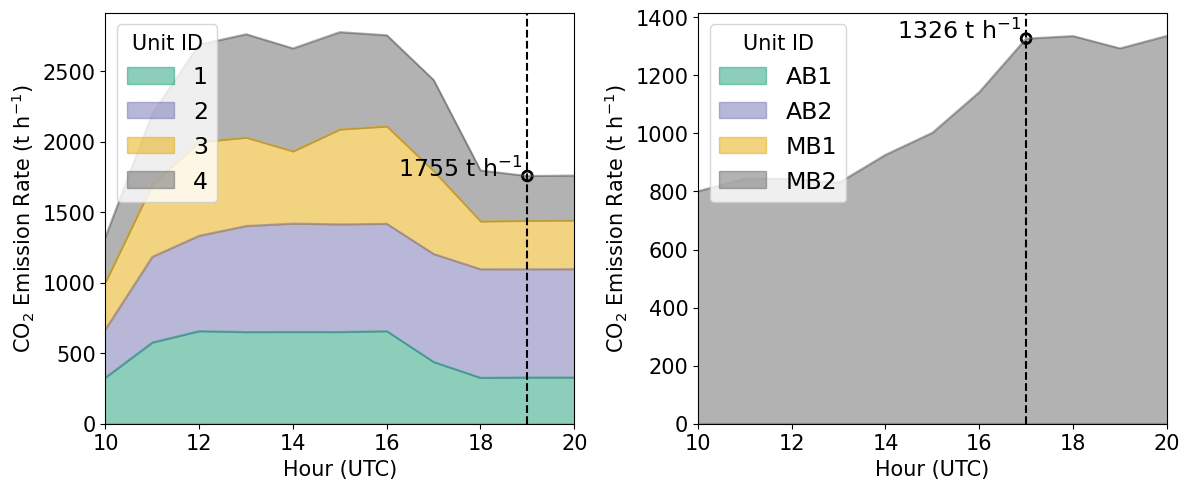

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

epa_emit = plot_tseries(axs[0], df_epa_emit, df_epa_emit_nearest)
epa_enmap = plot_tseries(axs[1], df_epa_enmap, df_epa_enmap_nearest)

fig.tight_layout()

## Plumes on map

In [12]:
# Get the colormap colors
cmap = plt.get_cmap('hot_r')
my_cmap = cmap(np.arange(cmap.N))

slopen = 30
my_cmap[:,-1][:slopen] = np.linspace(0.2, 1.0, slopen)
# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [13]:
def add_scalebar(ax, lon, lat):
    # add scalebar
    # Geographic WGS 84 - degrees
    scale_points = gpd.GeoSeries([Point(lon-1, lat),
                                  Point(lon, lat)],
                                 crs=4326)

    # UTM projection
    utm_crs_list = query_utm_crs_info(
        datum_name='WGS 84',
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon,
            south_lat_degree=lat,
            east_lon_degree=lon,
            north_lat_degree=lat,
        ),
    )
    utm_epsg = CRS.from_epsg(utm_crs_list[0].code).to_epsg()

    # Projected WGS 84 - meters
    scale_points = scale_points.to_crs(utm_epsg)

    distance_meters = scale_points[0].distance(scale_points[1])
    scale_bar_location = 'lower left'
    
    scalebar = ScaleBar(distance_meters,
                        location=scale_bar_location,
                        color='w',
                        box_alpha=0,
                        font_properties={'size': 10},
                        )
    
    ax.add_artist(scalebar)

In [14]:
def add_time(df, ax, lon, lat, proj):
    title = df['platform'].item() + '\n' + df['datetime'].item().replace('T', ' ')[:-3]+' (UTC)'
    ax.text(lon, lat, title, transform=proj, color='w', fontsize=17, weight='bold')

In [15]:
def add_wind(df, ax, lon, lat, pad, proj):
    wspd = df['wind_speed'].item()
    wdir = df['wind_direction'].item()
    u = -wspd * np.sin(np.radians(wdir))
    v = -wspd * np.cos(np.radians(wdir))
    q_era5 = ax.quiver(
                    # lon+pad/10, lat+pad/3,
                    lon, lat,
                       u, v,
                       transform=proj, color='w', zorder=100,
                      )

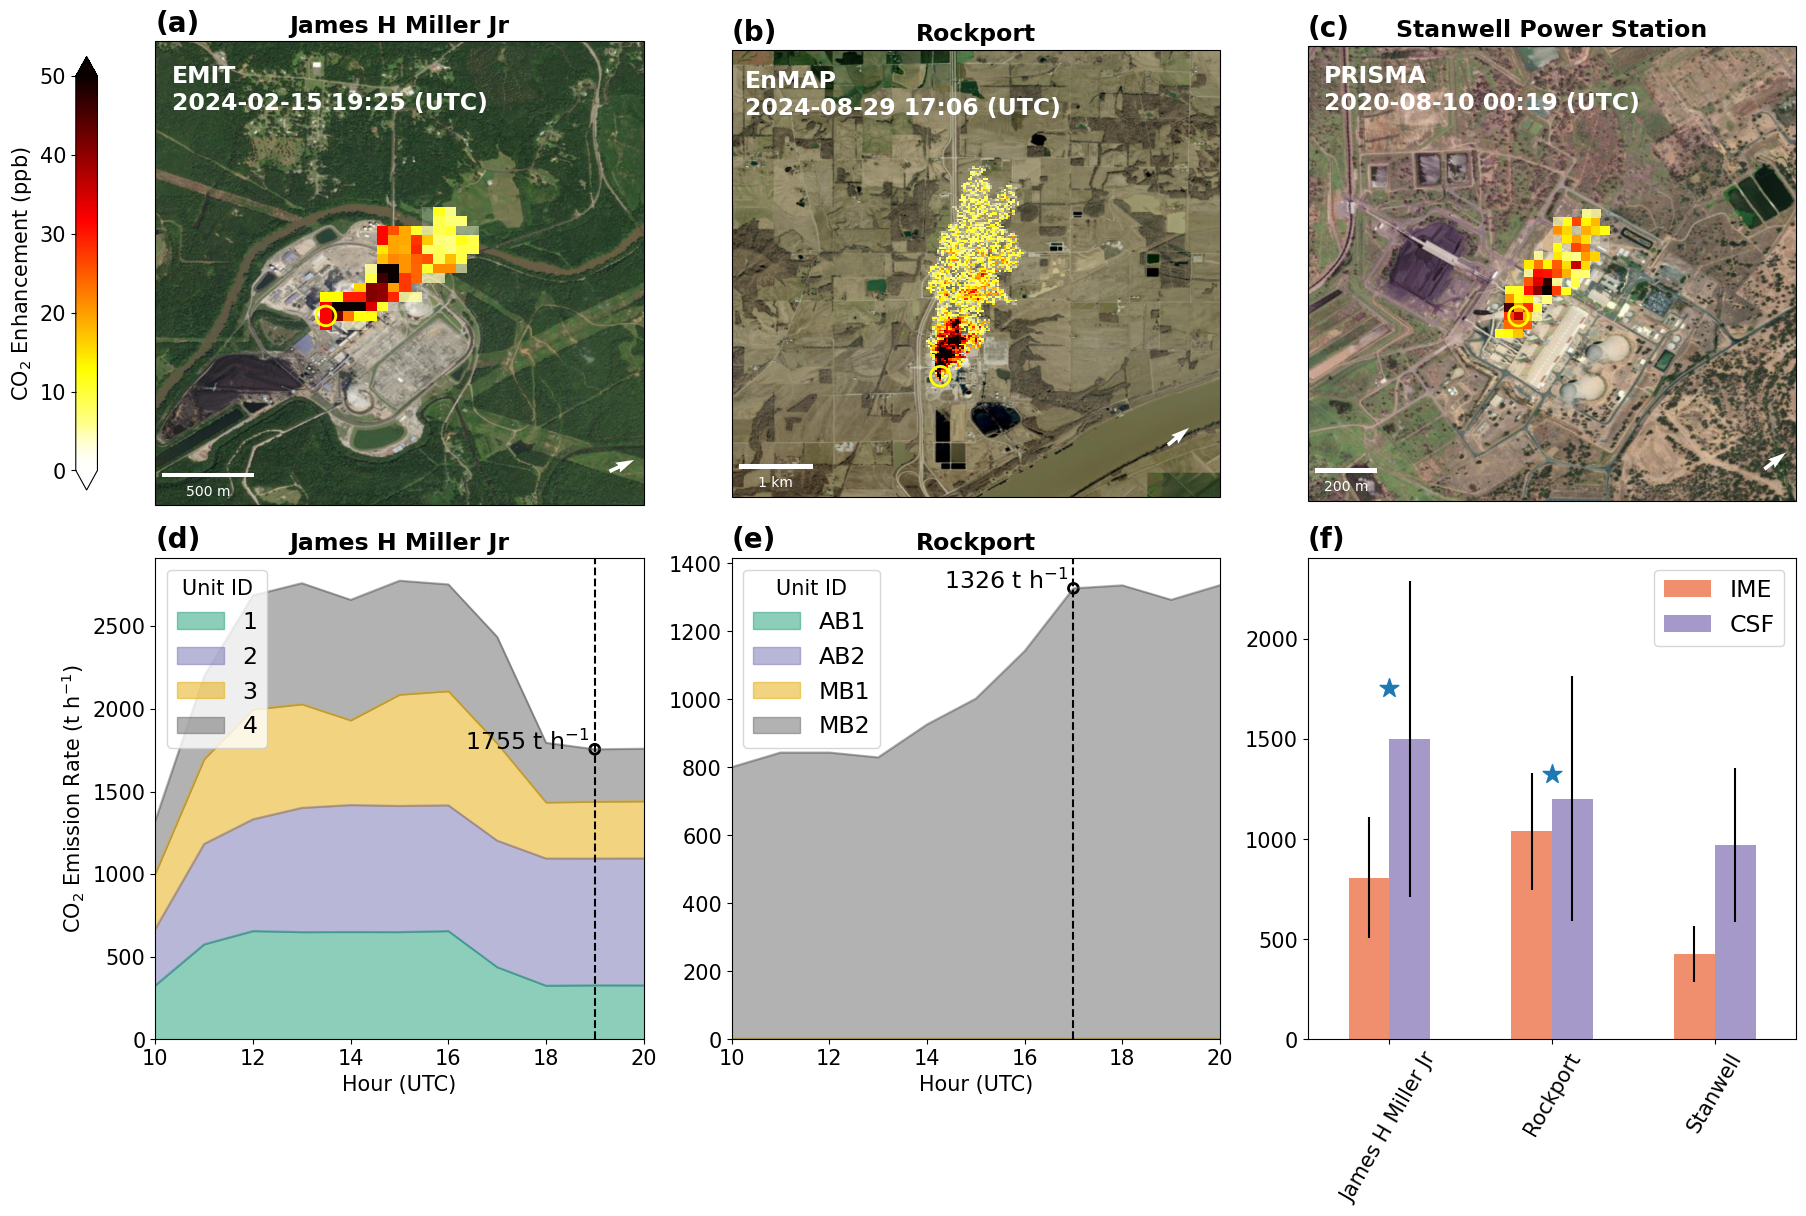

In [16]:
fig = plt.figure(figsize=(18, 12), constrained_layout=True)
proj = ccrs.PlateCarree()

# Create a 2x2 layout manually
ax1 = fig.add_subplot(2, 3, 1, projection=proj)
ax2 = fig.add_subplot(2, 3, 2, projection=proj)
ax3 = fig.add_subplot(2, 3, 3, projection=proj)

# Last one is a normal subplot (no projection)
ax4 = fig.add_subplot(2, 3, 4)  # No projection keyword
ax5 = fig.add_subplot(2, 3, 5)  # No projection keyword
ax6 = fig.add_subplot(2, 3, 6)  # No projection keyword

vmax = 50

# ---- EMIT ---- #
# set extent
bounds = df_emit['plume_bounds'].item()
pad = 0.01
lon_min = bounds[0] - pad
lon_max = bounds[2] + pad
lat_min = bounds[1] - pad
lat_max = bounds[3] + pad

ax1.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)


m = ds_emit['co2'].plot(ax=ax1, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, add_colorbar=False, rasterized=True)
ax1.scatter(df_emit['plume_longitude'], df_emit['plume_latitude'], transform=proj, color='yellow',
           linewidth=2, marker='o', fc='none', s=200)
add_scalebar(ax1, lon_min, lat_min)
add_time(df_emit, ax1, lon_min+pad*0.1, lat_max-pad*0.4, proj)
add_wind(df_emit, ax1, lon_max-pad*0.2, lat_min+pad*0.2, pad, proj)
ax1.set_title('James H Miller Jr')

# ---- EnMAP ---- #
# set extent
bounds = df_enmap['plume_bounds'].item()
pad = 0.02
lon_min = bounds[0] - pad*1.5
lon_max = bounds[2] + pad*1.5
lat_min = bounds[1] - pad*0.9
lat_max = bounds[3] + pad*0.9

ax2.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)

m = ds_enmap['co2'].plot(ax=ax2, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, add_colorbar=False, rasterized=True)
ax2.scatter(df_enmap['plume_longitude'], df_enmap['plume_latitude'], transform=proj, color='yellow',
           linewidth=2, marker='o', fc='none', s=200)
add_scalebar(ax2, lon_min, lat_min)
add_time(df_enmap, ax2, lon_min+pad*0.1, lat_max-pad*0.5, proj)
add_wind(df_enmap, ax2, lon_max-pad*0.4, lat_min+pad*0.4, pad, proj)
ax2.set_title('Rockport')

# ---- PRISMA ---- #
# set extent
bounds = df_prisma['plume_bounds'].item()
pad = 0.005
lon_min = bounds[0] - pad*1.2
lon_max = bounds[2] + pad*1.2
lat_min = bounds[1] - pad*1.05
lat_max = bounds[3] + pad*1.05

ax3.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)

m = ds_prisma['co2'].plot(ax=ax3, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, add_colorbar=False, rasterized=True)
ax3.scatter(df_prisma['plume_longitude'], df_prisma['plume_latitude'], transform=proj, color='yellow',
           linewidth=2, marker='o', fc='none', s=200)
add_scalebar(ax3, lon_min, lat_min)
add_time(df_prisma, ax3, lon_min+pad*0.1, lat_max-pad*0.4, proj)
add_wind(df_prisma, ax3, lon_max-pad*0.2, lat_min+pad*0.2, pad, proj)
ax3.set_title('Stanwell Power Station')

for ax in [ax1, ax2, ax3]:
    cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
    # remove attributions
    ax.texts[-1].remove()

# --- EPA comparison --- 
plot_tseries(ax4, df_epa_emit, df_epa_emit_nearest)
plot_tseries(ax5, df_epa_enmap, df_epa_enmap_nearest)
ax5.set_ylabel('')
ax4.set_title('James H Miller Jr')
ax5.set_title('Rockport')

# ---- emission rate ---- #
bar_plot = df_merge_mf.replace('JamesHMillerJr', 'James H Miller Jr')\
        .rename(columns={'emission': 'IME', 'emission_csf': 'CSF'})\
        .plot(x='name', y=['IME', 'CSF'],
              ax=ax6, rot=60, kind="bar",
              yerr=[df_merge_mf['emission_uncertainty'], df_merge_mf['emission_csf_uncertainty']],
              color=['#F08F6E', '#A599CA'],
             )

ax6.set_ylabel('')#CO$_2$ Emission Rates (t h$^{-1}$)')
ax6.set_xlabel('')

ax6.scatter(0, epa_emit, marker='*', c='C0', s=200)
ax6.scatter(1, epa_enmap, marker='*', c='C0', s=200)


for n, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6]):
    ax.text(0, 1.02, '({})'.format(string.ascii_lowercase[n]),
            transform=ax.transAxes, 
            size=20, weight='bold')

# add colorbar
fig.colorbar(m, ax=[ax1, ax2, ax3], label='CO$_2$ Enhancement (ppb)', extend='both', pad=-0.02, shrink=0.9, location='left')
# fig.savefig('../figures/co2_emiss_cases.pdf', bbox_inches='tight')

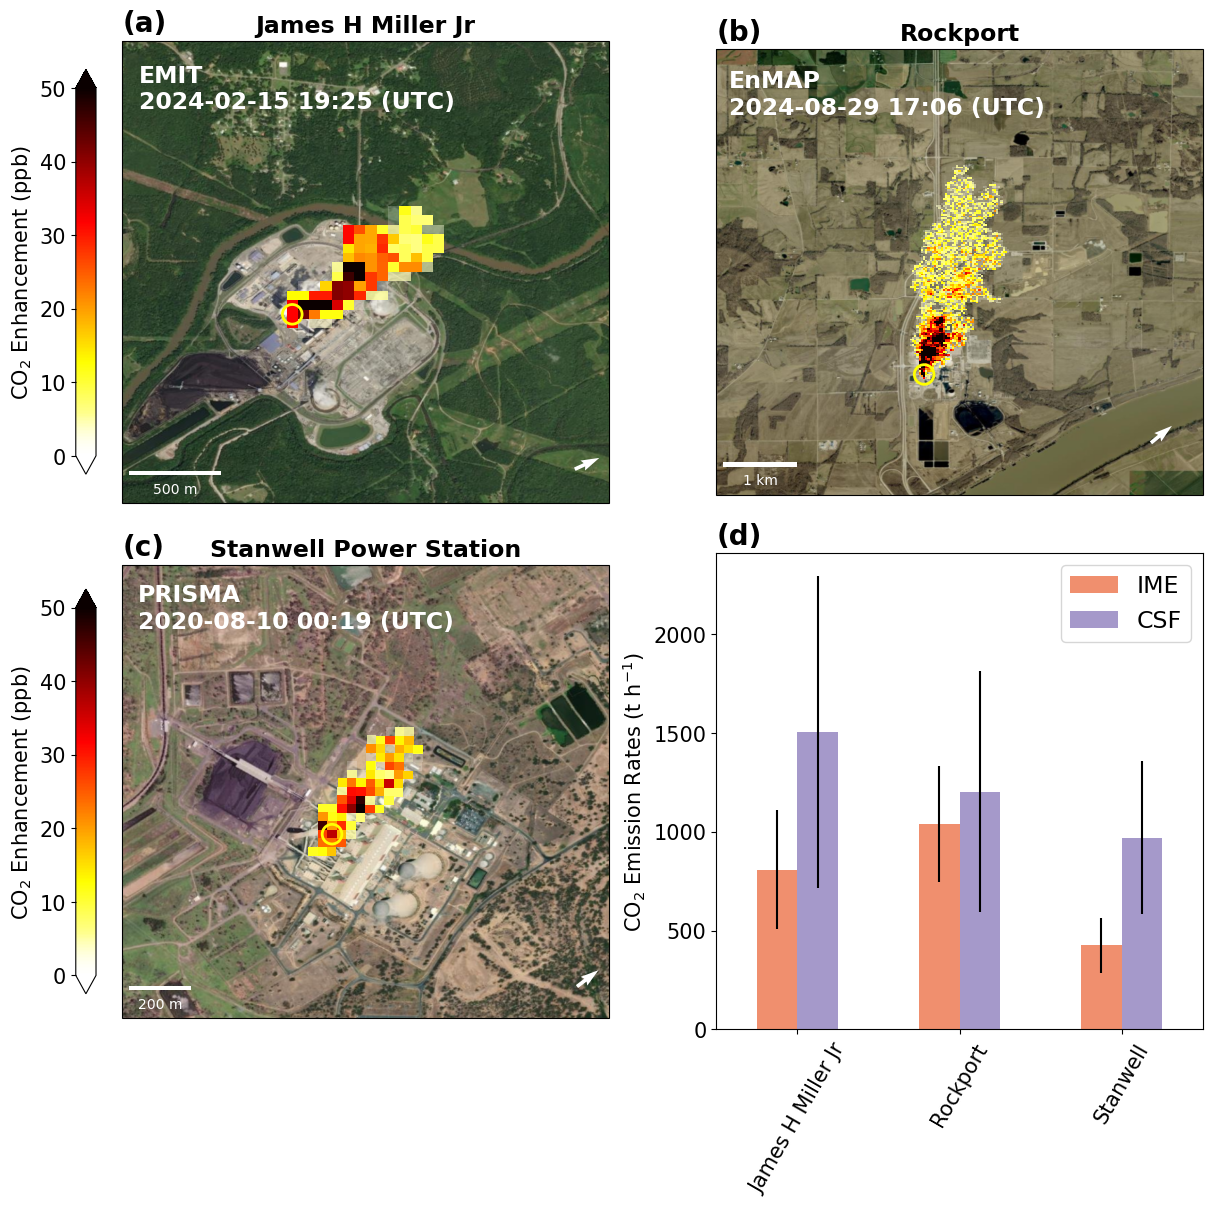

In [18]:
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
proj = ccrs.PlateCarree()

# Create a 2x2 layout manually
ax1 = fig.add_subplot(2, 2, 1, projection=proj)
ax2 = fig.add_subplot(2, 2, 2, projection=proj)
ax3 = fig.add_subplot(2, 2, 3, projection=proj)

# Last one is a normal subplot (no projection)
ax4 = fig.add_subplot(2, 2, 4)  # No projection keyword

vmax = 50

# ---- EMIT ---- #
# set extent
bounds = df_emit['plume_bounds'].item()
pad = 0.01
lon_min = bounds[0] - pad
lon_max = bounds[2] + pad
lat_min = bounds[1] - pad
lat_max = bounds[3] + pad

ax1.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)


m = ds_emit['co2'].plot(ax=ax1, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, rasterized=True,
                       cbar_kwargs={'label': 'CO$_2$ Enhancement (ppb)', 'extend':'both', 'shrink': 0.85, 'location': 'left'}
                       )
ax1.scatter(df_emit['plume_longitude'], df_emit['plume_latitude'], transform=proj, color='yellow',
           linewidth=2, marker='o', fc='none', s=200)
add_scalebar(ax1, lon_min, lat_min)
add_time(df_emit, ax1, lon_min+pad*0.1, lat_max-pad*0.4, proj)
add_wind(df_emit, ax1, lon_max-pad*0.2, lat_min+pad*0.2, pad, proj)
ax1.set_title('James H Miller Jr')

# ---- EnMAP ---- #
# set extent
bounds = df_enmap['plume_bounds'].item()
pad = 0.02
lon_min = bounds[0] - pad*1.5
lon_max = bounds[2] + pad*1.5
lat_min = bounds[1] - pad*0.9
lat_max = bounds[3] + pad*0.9

ax2.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)

m = ds_enmap['co2'].plot(ax=ax2, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, rasterized=True,
                         add_colorbar=False,
                       # cbar_kwargs={'label': 'CO$_2$ Enhancement (ppb)', 'extend':'both', 'shrink': 0.85, 'location': 'left'}
                       )
ax2.scatter(df_enmap['plume_longitude'], df_enmap['plume_latitude'], transform=proj, color='yellow',
           linewidth=2, marker='o', fc='none', s=200)
add_scalebar(ax2, lon_min, lat_min)
add_time(df_enmap, ax2, lon_min+pad*0.1, lat_max-pad*0.5, proj)
add_wind(df_enmap, ax2, lon_max-pad*0.4, lat_min+pad*0.4, pad, proj)
ax2.set_title('Rockport')

# ---- PRISMA ---- #
# set extent
bounds = df_prisma['plume_bounds'].item()
pad = 0.005
lon_min = bounds[0] - pad*1.2
lon_max = bounds[2] + pad*1.2
lat_min = bounds[1] - pad*1.05
lat_max = bounds[3] + pad*1.05

ax3.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)

m = ds_prisma['co2'].plot(ax=ax3, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap=my_cmap, rasterized=True,
                       cbar_kwargs={'label': 'CO$_2$ Enhancement (ppb)', 'extend':'both', 'shrink': 0.85, 'location': 'left'}
                       )
ax3.scatter(df_prisma['plume_longitude'], df_prisma['plume_latitude'], transform=proj, color='yellow',
           linewidth=2, marker='o', fc='none', s=200)
add_scalebar(ax3, lon_min, lat_min)
add_time(df_prisma, ax3, lon_min+pad*0.1, lat_max-pad*0.4, proj)
add_wind(df_prisma, ax3, lon_max-pad*0.2, lat_min+pad*0.2, pad, proj)
ax3.set_title('Stanwell Power Station')

for ax in [ax1, ax2, ax3]:
    cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
    # remove attributions
    ax.texts[-1].remove()

# ---- emission rate ---- #
bar_plot = df_merge_mf.replace('JamesHMillerJr', 'James H Miller Jr')\
        .rename(columns={'emission': 'IME', 'emission_csf': 'CSF'})\
        .plot(x='name', y=['IME', 'CSF'],
              ax=ax4, rot=60, kind="bar",
              yerr=[df_merge_mf['emission_uncertainty'], df_merge_mf['emission_csf_uncertainty']],
              color=['#F08F6E', '#A599CA'],
             )

ax4.set_ylabel('CO$_2$ Emission Rates (t h$^{-1}$)')
ax4.set_xlabel('')

for n, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.text(0, 1.02, '({})'.format(string.ascii_lowercase[n]),
            transform=ax.transAxes, 
            size=20, weight='bold')

# add colorbar
# fig.colorbar(m, ax=[ax1, ax2, ax3], label='CO$_2$ Enhancement (ppb)', extend='both', pad=-0.02, shrink=0.9, location='left')
fig.savefig('../figures/co2_emiss_cases.pdf', bbox_inches='tight')